# Usage GB Framework

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import xgboost as xgb
from gradient_boosting.methods import Regressor, Classifier 

## Classification Problem with gb_framework

In [6]:
from sklearn.datasets.samples_generator import make_blobs
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=5, n_features=5, cluster_std=2.)
# scatter plot, dots colored by class value
mydict = {'feature_{0}'.format(i): X[:, i] for i in range(5)}
mydict.update({'random_feature': np.random.random(X.shape[0])})
mydict.update({'label': y})
data = pd.DataFrame(mydict)

In [7]:
data.head()

feature_0  feature_1  feature_2  feature_3  feature_4  label  \
0  -1.990959  -3.512141 -11.833176 -10.645850   3.159374      0   
1   7.906965   3.469142   5.665771  -4.905563  -7.351679      4   
2  -3.183011  10.483629   8.471340   6.755470   8.361680      3   
3  -4.678544  -1.774074  -6.784496  -7.557793   4.875628      0   
4   3.551863  -1.466494  -2.971563   1.827621   0.814837      2   

   random_feature  
0        0.569841  
1        0.403077  
2        0.816940  
3        0.712567  
4        0.978677

In [8]:
features = ['feature_{0}'.format(i) for i in range(5)]
features += ['random_feature']
x_data = data[features]
y_data = data['label']

In [9]:
seed = 42
test_size = 0.3
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, 
                                                                    test_size=test_size, 
                                                                    random_state=seed)

In [10]:
default_params = {'objective': 'multi:softprob', 'reg_lambda': 1, 'random_state': 0, 'n_jobs': 1, 
                  'scale_pos_weight': 1, 'subsample': 1, 'reg_alpha': 0, 'max_delta_step': 0, 
                  'min_child_weight': 1, 'n_estimators': 1000, 'learning_rate': 0.1, 
                  'colsample_bylevel': 1, 'gamma': 0, 'colsample_bytree': 1, 'booster': 'gbtree', 'max_depth': 3, 
                  'silent': True, 'seed': 0, 'base_score': 0.5}

In [11]:
type(x_train)

pandas.core.frame.DataFrame

In [12]:
myclassifier = Classifier(**default_params)
myclassifier.train(x_train, y_train)

In [13]:
%%capture --no-stdout
myclassifier.get_importance()

In [14]:
%%capture --no-stdout
mscore = myclassifier.score(x_test, y_test, method='matthews')

In [15]:
mscore

0.9958441068403023

In [16]:
%%capture --no-stdout
acc_score = myclassifier.score(x_test, y_test, method='accuracy')

In [17]:
acc_score

0.9966666666666667

In [18]:
fig, ax = plt.subplots()
myclassifier.plot_scatter(x_test, y_test, ax=ax, alpha=0.1)
plt.show()

In [19]:
%%capture --no-stdout
label_predictions = myclassifier.predict(x_data)

In [20]:
%%capture --no-stdout
probabilities = myclassifier.predict_proba(x_data)

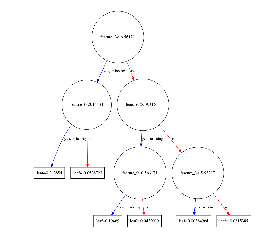

In [21]:
myclassifier.plot_example_tree('/workspace/projects/genomewide_MMR/notebooks/example_tree.png', dpi=400)

In [22]:
# get estimators
trees = list(myclassifier.get_estimators())
trees[:5]

['0:[feature_3<-6.56171] yes=1,no=2,missing=1,gain=246.478,cover=224\n\t1:[feature_0<3.14104] yes=3,no=4,missing=3,gain=49.3076,cover=45.76\n\t\t3:leaf=0.243854,cover=39.68\n\t\t4:leaf=-0.0536723,cover=6.08\n\t2:[feature_2<-9.21611] yes=5,no=6,missing=5,gain=18.3618,cover=178.24\n\t\t5:[feature_0<0.563171] yes=7,no=8,missing=7,gain=9.63709,cover=5.76\n\t\t\t7:leaf=0.19469,cover=3.52\n\t\t\t8:leaf=-0.0432099,cover=2.24\n\t\t6:[feature_3<-5.93297] yes=9,no=10,missing=9,gain=1.89962,cover=172.48\n\t\t\t9:leaf=0.00364964,cover=4.48\n\t\t\t10:leaf=-0.0615385,cover=168\n',
 '0:[feature_1<5.35871] yes=1,no=2,missing=1,gain=74.4363,cover=224\n\t1:[feature_1<3.6169] yes=3,no=4,missing=3,gain=2.07565,cover=116.48\n\t\t3:[feature_2<8.41152] yes=7,no=8,missing=7,gain=0.267468,cover=98.56\n\t\t\t7:leaf=-0.0618535,cover=95.68\n\t\t\t8:leaf=-0.0206186,cover=2.88\n\t\t4:[feature_0<3.00404] yes=9,no=10,missing=9,gain=8.57483,cover=17.92\n\t\t\t9:leaf=0.0950413,cover=3.84\n\t\t\t10:leaf=-0.0583554,cover

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))
myclassifier.plot_importance('gain', axes[0], std_kwarg=False)
myclassifier.plot_importance('cover', axes[1], std_kwarg=False)
myclassifier.plot_importance('permutation', axes[2], std_kwarg=False)
plt.show()

In [24]:
myclassifier.add_partial_dependence(['feature_4'])

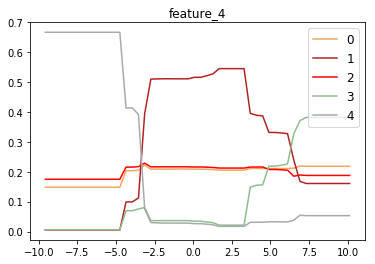

In [25]:
fig, axes = plt.subplots()
myclassifier.plot_partial_dependence('feature_4', ax=axes)
plt.show()

In [26]:
# run many cross validations
myclassifier.cv()
# plot the outcome
fig, axes = plt.subplots(figsize=(10, 4))
myclassifier.plot_cv(axes)
plt.show()

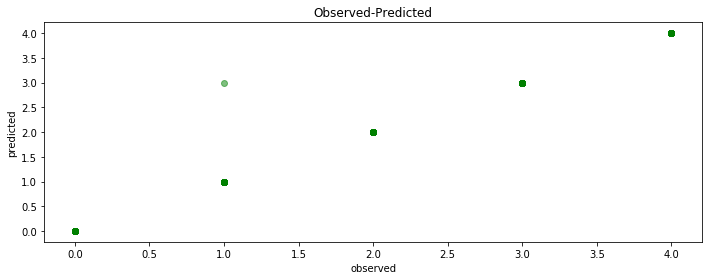

In [27]:
fig, axes = plt.subplots(figsize=(10, 4))
myclassifier.plot_scatter(x_data, y_data, axes, alpha=0.5)
plt.show()

## Regression

In [28]:
def construct_analysis_table(tumor_type, my_cluster, path_to_table, covariates, response):
    raw_table = pd.read_csv(path_to_table, sep='\t')
    raw_table = raw_table[raw_table[tumor_type + '_' + my_cluster + '_' + 'mutations'] != 0]
    table = raw_table[covariates].copy()
    exp = '_'.join([tumor_type, my_cluster, 'expected_muts'])
    obs = '_'.join([tumor_type, my_cluster, 'mutations'])
    table[response] = (raw_table[obs] - raw_table[exp]) / raw_table[exp] 
    return table

In [29]:
tumor_type = 'crc'    # options: 'crc', 'bMMRD'
cluster = 'clusterA'  # options: 'clusterA', 'clusterB'
curr_chunk = '100kb'  # options: '1Mb', '100kb', '10000bp'
PATH_DATA = '/workspace/projects/genomewide_MMR/data/'
path_to_table = os.path.join(PATH_DATA, curr_chunk + '_segments_data_v8.txt')
covariates = ['E075_H3K27ac_covered_bp', 'E075_H3K27me3_covered_bp', 'E075_H3K36me3_covered_bp']
response = 'rel_diff' + '_' + tumor_type + '_' + cluster + '_mutations'
table = construct_analysis_table(tumor_type, cluster, path_to_table, covariates, response)

In [30]:
import pickle

mypickle = '/workspace/projects/genomewide_MMR/results/feature_importance/crc_clusterA_100kb_rel_diff_crc_clusterA_mutations.pickle'

with open(mypickle, 'rb') as f:
    outcome = pickle.load(f)
params = outcome['params']
params['n_estimators'] = 100

In [31]:
myregressor = Regressor(**params)

x_data = table[covariates]
y_data = table[response]
myregressor.train(x_data, y_data)

In [32]:
myregressor.get_mutual_information(x_data, y_data)

{'E075_H3K27ac_covered_bp': 2,
 'E075_H3K27me3_covered_bp': 3,
 'E075_H3K36me3_covered_bp': 1}

In [33]:
myregressor.get_importance(method='mse')
myregressor.feat_imp

{'cover': {'E075_H3K27ac_covered_bp': 11932.662983425414,
  'E075_H3K27me3_covered_bp': 11417.888,
  'E075_H3K36me3_covered_bp': 9809.420454545454},
 'gain': {'E075_H3K27ac_covered_bp': 77.07400392265194,
  'E075_H3K27me3_covered_bp': 18.20655296,
  'E075_H3K36me3_covered_bp': 79.69742017045455},
 'permutation': {'E075_H3K27ac_covered_bp': -0.041738905578859925,
  'E075_H3K27me3_covered_bp': -0.005519695170245725,
  'E075_H3K36me3_covered_bp': -0.04223006370957463}}

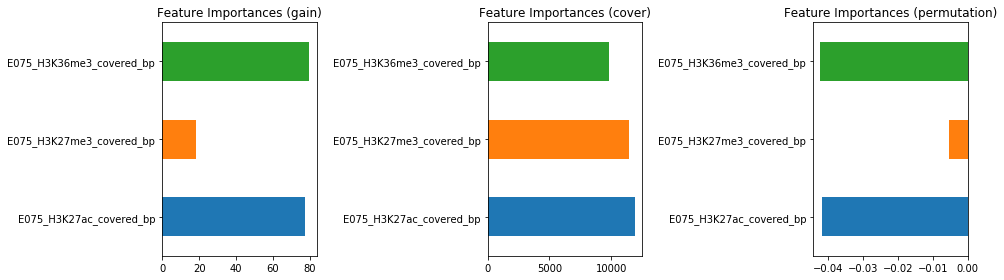

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
myregressor.plot_importance('gain', axes[0], std_kwarg=False)
myregressor.plot_importance('cover', axes[1], std_kwarg=False)
myregressor.plot_importance('permutation', axes[2], std_kwarg=False)
plt.show()

In [36]:
myregressor.permutation_importance(method='r2')

In [37]:
print(myregressor.feat_imp)
print(myregressor.feat_imp_std)

{'cover': {'E075_H3K27ac_covered_bp': 11932.662983425414, 'E075_H3K36me3_covered_bp': 9809.420454545454, 'E075_H3K27me3_covered_bp': 11417.888}, 'gain': {'E075_H3K27ac_covered_bp': 77.07400392265194, 'E075_H3K36me3_covered_bp': 79.69742017045455, 'E075_H3K27me3_covered_bp': 18.20655296}, 'permutation': {'E075_H3K27ac_covered_bp': 0.20851843675375115, 'E075_H3K27me3_covered_bp': 0.02655656325879252, 'E075_H3K36me3_covered_bp': 0.20276899603373955}}
{'cover': {'E075_H3K27ac_covered_bp': 5973.282112525081, 'E075_H3K36me3_covered_bp': 6639.216669329966, 'E075_H3K27me3_covered_bp': 6262.649497094341}, 'gain': {'E075_H3K27ac_covered_bp': 132.1568532480241, 'E075_H3K36me3_covered_bp': 171.06220987139818, 'E075_H3K27me3_covered_bp': 28.676410898145072}, 'permutation': {'E075_H3K27ac_covered_bp': 0, 'E075_H3K27me3_covered_bp': 0, 'E075_H3K36me3_covered_bp': 0}}


In [38]:
myregressor.get_mutual_information(x_data, y_data)

{'E075_H3K27ac_covered_bp': 2,
 'E075_H3K27me3_covered_bp': 3,
 'E075_H3K36me3_covered_bp': 1}

In [39]:
myregressor.predict(x_data)

array([ 0.1841931 ,  0.3398353 , -0.11903059, ..., -0.27304918,
       -0.28656983, -0.2571571 ], dtype=float32)

In [40]:
x = myregressor.x_data.copy()
x['E075_H3K27ac_covered_bp'].values

array([    0,     0,  3799, ..., 27146, 14809,  5192])

In [41]:
x_data.values

array([[    0,     0,   664],
       [    0,     0,     0],
       [ 3799,   726,  1962],
       ...,
       [27146,  7292,  4865],
       [14809, 10485,  5674],
       [ 5192,  7697, 11389]])

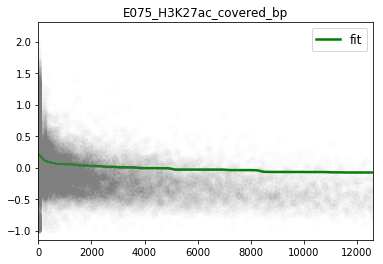

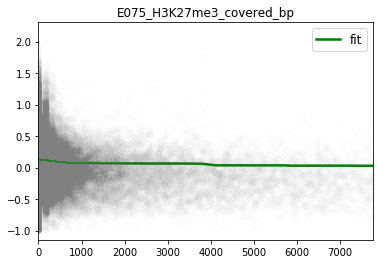

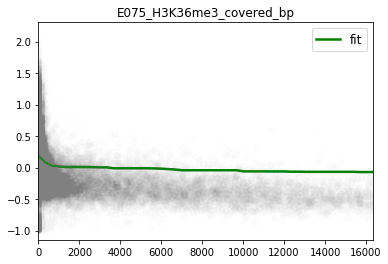

In [42]:
for feat in covariates:
    fig, axes = plt.subplots()
    myregressor.add_partial_dependence([feat])
    myregressor.plot_partial_dependence(feat, axes, linewidth=2.5)
    axes.plot(x_data[feat].values, y_data.values, 'o', color='grey', alpha=0.01)
    plt.show()

## Evaluation

In [43]:
myregressor.score(x_data, y_data, method='variance')

0.4106995460198666

In [44]:
myregressor.score(x_data, y_data, method='r2')

0.37764497941892605

In [45]:
myregressor.score(x_data, y_data, method='mse')

0.12371748763566259

In [46]:
myregressor.cv()

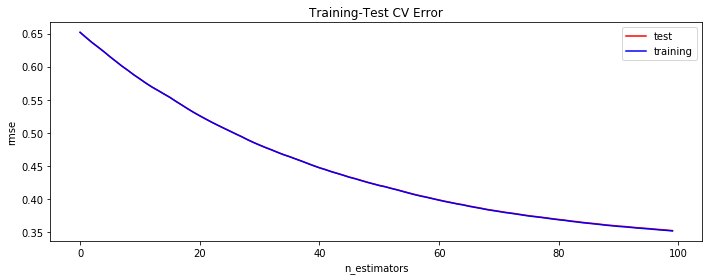

In [47]:
fig, axes = plt.subplots(figsize=(10,4))
myregressor.plot_cv(axes)
plt.show()

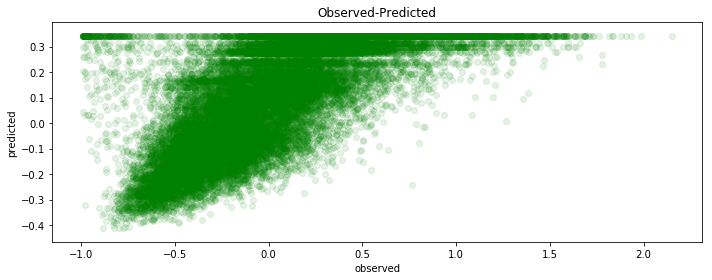

In [48]:
fig, axes = plt.subplots(figsize=(10,4))
myregressor.plot_scatter(axes, alpha=0.1)
plt.show()

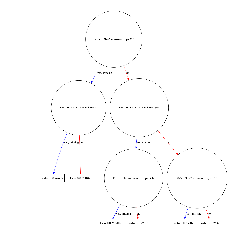

In [49]:
myregressor.plot_example_tree('/workspace/projects/genomewide_MMR/notebooks/example_tree.png', dpi=400)